In [11]:
import keras
keras.__version__

'2.4.3'

In [12]:
from keras import models
from keras import layers
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras import optimizers
from keras.layers.normalization import BatchNormalization

(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
train_images.shape

(50000, 32, 32, 3)

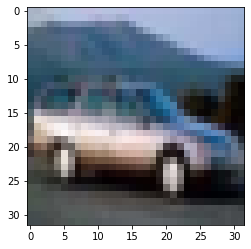

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

digit = train_images[4]
plt.imshow(digit, cmap=plt.cm.binary)

plt.show()

In [14]:
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

validation_indexes = np.random.choice(
    range(len(train_images)),
    size=10000, 
    replace=False
)

train_indexes = np.isin(
    range(len(train_images)), 
    validation_indexes, 
    invert=True
)

train_data = train_images[train_indexes]
validation_data = train_images[validation_indexes]

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

train_data_labels = train_labels[train_indexes]
validation_data_labels = train_labels[validation_indexes]

train_generator = ImageDataGenerator(
    # rescale=1./255,
    # featurewise_center=True,
    # featurewise_std_normalization=True,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
)

train_generator.fit(train_data)

validation_generator = ImageDataGenerator(
    # featurewise_center=True,
    # featurewise_std_normalization=True
    # rescale=1./255,
)

validation_generator.fit(validation_data)

test_generator = ImageDataGenerator(
    # rescale=1./255
)

test_generator.fit(test_images)


train_data.shape, train_data_labels.shape, validation_data.shape, \
validation_data_labels.shape, test_images.shape, test_labels.shape

((40000, 32, 32, 3),
 (40000, 10),
 (10000, 32, 32, 3),
 (10000, 10),
 (10000, 32, 32, 3),
 (10000, 10))

In [15]:
from keras import applications

conv_base = applications.DenseNet201(
    include_top=False,
    weights='imagenet',
    input_shape=(32, 32, 3),
)

conv_base.summary()

Model: "densenet201"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 38, 38, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 16, 16, 64)   9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [16]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())

model.add(layers.Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(layers.Dropout(0.25))

model.add(layers.Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(layers.Dropout(0.25))

model.add(layers.Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(layers.Dropout(0.25))

model.add(layers.Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(layers.Dropout(0.25))

model.add(layers.Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(layers.Dropout(0.25))

model.add(layers.Dense(10, activation='softmax'))

In [17]:
# conv_base.trainable = False

import re

# block_pattern = r'block(\d)_conv\d'
block_pattern = r'conv(\d+)_block(\d+).+'
regex = re.compile(block_pattern)

for layer in conv_base.layers:
  layer.trainable = False
  block = regex.search(layer.name)
  if block:
    conv_num = int(block.group(1))
    block_num = int(block.group(2))
    if conv_num > 2:
      layer.trainable = True


model.compile(optimizer='adam', 
              loss='categorical_crossentropy',
              metrics=['accuracy']
              )
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 1, 1, 1920)        18321984  
_________________________________________________________________
flatten_1 (Flatten)          (None, 1920)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              1967104   
_________________________________________________________________
batch_normalization_5 (Batch (None, 1024)              4096      
_________________________________________________________________
dropout_5 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               524800    
_________________________________________________________________
batch_normalization_6 (Batch (None, 512)              

In [18]:
epochs=50
preprocess = keras.applications.densenet.preprocess_input
"""model_hist = model.fit(train_generator.flow(
      train_data, train_data_labels, batch_size=128
    ), 
    validation_data = validation_generator.flow(
        validation_data, validation_data_labels, batch_size=128
    ),
    steps_per_epoch = len(train_data)//128,
    validation_steps = len(validation_data)//128,
    epochs=epochs,
) """

model_hist = model.fit(
    train_generator.flow(
        preprocess(train_data), 
        train_data_labels, 
        batch_size=64
    ),
    validation_data=validation_generator.flow(
        preprocess(validation_data), 
        validation_data_labels,
        batch_size=64
    ), 
    steps_per_epoch = len(train_data)//64,
    validation_steps = len(validation_data)//64,
    epochs=epochs,
)

Epoch 1/50
625/625 [==============================] - 74s 93ms/step - loss: 1.9765 - accuracy: 0.3436 - val_loss: 1.3616 - val_accuracy: 0.5835
Epoch 2/50
625/625 [==============================] - 55s 88ms/step - loss: 1.1316 - accuracy: 0.6270 - val_loss: 1.0279 - val_accuracy: 0.6883
Epoch 3/50
625/625 [==============================] - 56s 90ms/step - loss: 1.0144 - accuracy: 0.6662 - val_loss: 1.1138 - val_accuracy: 0.6609
Epoch 4/50
625/625 [==============================] - 56s 89ms/step - loss: 0.9701 - accuracy: 0.6763 - val_loss: 0.8426 - val_accuracy: 0.7150
Epoch 5/50
625/625 [==============================] - 57s 91ms/step - loss: 0.9403 - accuracy: 0.6869 - val_loss: 0.7882 - val_accuracy: 0.7430
Epoch 6/50
625/625 [==============================] - 55s 88ms/step - loss: 0.8389 - accuracy: 0.7209 - val_loss: 0.7325 - val_accuracy: 0.7552
Epoch 7/50
625/625 [==============================] - 56s 89ms/step - loss: 0.7934 - accuracy: 0.7364 - val_loss: 0.6580 - val_accuracy:

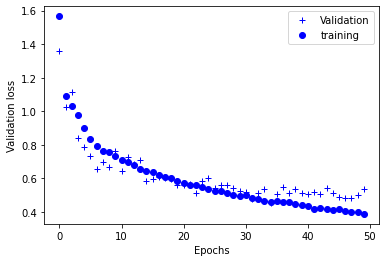

In [19]:
epochs = range(0, epochs)
train_loss = model_hist.history['loss']
val_loss= model_hist.history['val_loss']

plt.plot(epochs, val_loss, 'b+', label='Validation')
plt.plot(epochs, train_loss, 'bo', label='training')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()

In [20]:
test_loss, test_acc = model.evaluate(preprocess(test_images), test_labels)
print('test_acc:', test_acc)
test_loss

313/313 [==============================] - 9s 19ms/step - loss: 0.5319 - accuracy: 0.8331
test_acc: 0.8331000208854675


0.531877875328064

In [21]:
model.save_weights('./cifar10_pretrained.h5', overwrite=True)